# <font color=#7db61c> Machine Learning en Python: Automatización NLP</font>



En este notebook se muestra la aplicación de pipelines y validación cruzada al problema de clasificación de textos de reviews de IMDB.

## Clasificación de textos con pipelines

A continuación se muestra una implementación del clasificador de reviews de películas de la clase anterior utilizando pipelines y selección de hiperparámetros.

In [1]:
import os
import math
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.externals.joblib import Memory

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
p_stem = PorterStemmer().stem
s_words = set(stopwords.words('english'))|{'', 'br'}

### Definición de los transformadores y pipelines

In [3]:
class SimpleTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words=False, stemmer=False, delete_chars=string.punctuation):
        self.delete_chars = delete_chars
        self.stop_words = stop_words
        self.stemmer = stemmer
    
    def _get_words(self, txt):
        word_list = (''.join([c if c not in self.delete_chars else ' ' for c in txt.lower()])).split(' ')
        stem = p_stem if self.stemmer else lambda w: w 
        s_word_set = s_words if self.stop_words else set()
        return list([stem(w) for w in word_list if w not in s_word_set])
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return list([self._get_words(di) for di in X])

In [4]:
class SimpleVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, min_count=0):
        self.min_count = min_count
    
    def _text_to_vec(self, words):
        word_counts = np.zeros((1,len(self._word_dict)))
        for w in words:
            if w in self._word_dict:
                word_counts[0,self._word_dict[w]] += 1
        return word_counts
   
    def fit(self, X, y=None):
        self._word_list = sorted(list(set(sum(X,[]))))
        self._word_dict = {w:i for i, w in enumerate(self._word_list)}
        self._word_counts = np.sum(self.transform(X), axis=0, keepdims=True)
        
        if self.min_count > 0:
            filt = self._word_counts[0,:] > self.min_count
            self._word_list = [w for w, f in zip(self._word_list, filt) if f]
            self._word_dict = {wi:ni for ni, wi in enumerate(self._word_list)}
            self._word_counts = np.sum(self.transform(X), axis=0, keepdims=True)
        return self
    
    def transform(self, X, y=None):
        return np.concatenate([self._text_to_vec(stl) for stl in X], axis=0)

In [5]:
class TfIdf(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self._idf = 1 + np.log(X.shape[0] / np.sum(X > 0, axis=0, keepdims=True))
        return self
    
    def transform(self, X, y=None):
        return X*self._idf

In [6]:
pip_extr = Pipeline([('tokenizer', SimpleTokenizer(stop_words=False, stemmer=False)), 
                     ('vectorizer', SimpleVectorizer(min_count=50)),
                     ('tfidf', TfIdf()),
                     ('linear_svc', ExtraTreesClassifier(n_estimators=250, random_state=123))])

### Carga de datos

In [7]:
pth = '/Users/....' #incorporar path donde se encuentra el dataset
train_folders = ['train/pos/', 'train/neg/']
test_folders = ['test/pos/', 'test/neg/']

In [8]:
def readf(fn):
    with open(fn, 'r', encoding='utf8') as ff:
        ftx = ff.read()
    return ftx

In [9]:
train_files = sum([[pth+fold+fn for fn in os.listdir(pth+fold)[::10]] for fold in train_folders],[])
test_files = sum([[pth+fold+fn for fn in os.listdir(pth+fold)[::10]] for fold in test_folders],[])
n_tr = int(len(train_files)/2)
n_te = int(len(test_files)/2)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/IBM_ADMIN/PythonNLP/aclImdb/train/pos/'

In [10]:
X_train = [readf(fi) for fi in train_files]
y_train = np.array([1]*n_tr + [-1]*n_tr)
X_test = [readf(fi) for fi in test_files]
y_test = np.array([1]*n_te + [-1]*n_te)

NameError: name 'train_files' is not defined

### Pruebas

In [11]:
pip_extr.fit(X_train, y_train)
print(pip_extr.score(X_train, y_train))
print(pip_extr.score(X_test, y_test))
wcc = pip_extr.steps[1][1]
len(wcc._word_list)

1.0
0.8452


1149

### Búsqueda de hiperparámetros

In [12]:
min_count_list = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100]

In [ ]:
imdb_grid = GridSearchCV(pip_extr,
                         param_grid={'tokenizer__stop_words': [True, False],
                                     'tokenizer__stemmer': [True, False],
                                     'vectorizer__min_count': min_count_list},
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         refit=True)
imdb_grid.fit(X_train, y_train)

In [13]:
import pickle
with open('imdb_grid_obj2.dat', 'rb') as ff:
    imdb_grid = pickle.load(ff)

In [14]:
imdb_grid_res = [(np.mean(fi[2]), np.std(fi[2]), 
                  ('No ' if not fi[0]['tokenizer__stop_words'] else '') + 'Stop Words, ' +  
                  ('No ' if not fi[0]['tokenizer__stemmer'] else '') + 'Stemmer', 
                  fi[0]['vectorizer__min_count']) for i , fi in enumerate(imdb_grid.grid_scores_)]

C:\Users\IBM_ADMIN\Anaconda3\envs\py_ree\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [15]:
imdb_grid_res

[(0.84199999999999997, 0.024673872821265822, 'Stop Words, Stemmer', 0),
 (0.8408000000000001, 0.023033888078220734, 'Stop Words, Stemmer', 1),
 (0.8488, 0.016761861471805587, 'Stop Words, Stemmer', 2),
 (0.84519999999999995, 0.030986448650982903, 'Stop Words, Stemmer', 3),
 (0.83719999999999994, 0.0062096698785040153, 'Stop Words, Stemmer', 4),
 (0.84040000000000004, 0.019550959055759893, 'Stop Words, Stemmer', 5),
 (0.84040000000000004, 0.02362710308099578, 'Stop Words, Stemmer', 10),
 (0.83079999999999998, 0.019353552645444701, 'Stop Words, Stemmer', 20),
 (0.82119999999999993, 0.01688075827680733, 'Stop Words, Stemmer', 50),
 (0.81679999999999997, 0.013242356285797447, 'Stop Words, Stemmer', 100),
 (0.84000000000000008, 0.017888543819998333, 'No Stop Words, Stemmer', 0),
 (0.8428000000000001, 0.021245234759823199, 'No Stop Words, Stemmer', 1),
 (0.8348000000000001, 0.017255723688098371, 'No Stop Words, Stemmer', 2),
 (0.83160000000000012, 0.024228908353452479, 'No Stop Words, Stemme

In [16]:
imdb_res_dict = {rw[2]:[rw2[0] for rw2 in imdb_grid_res if rw2[2]==rw[2]] for rw in imdb_grid_res}
imdb_res_df = pd.DataFrame(imdb_res_dict, index=min_count_list)

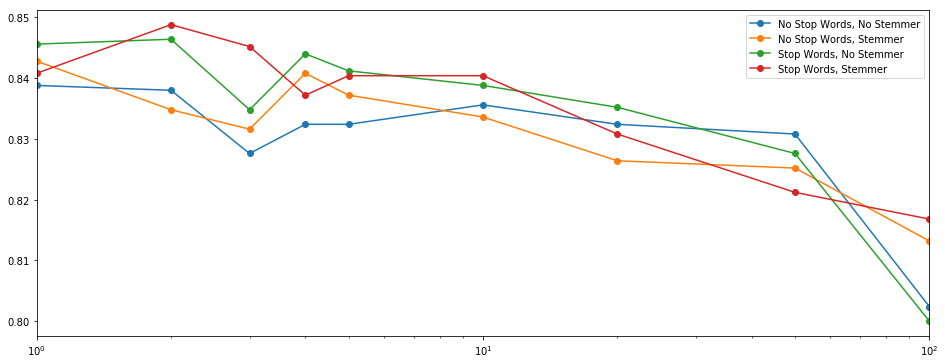

In [17]:
imdb_res_df.plot(figsize=(16,6), logx=True, marker='o')

In [18]:
imdb_grid.best_params_

{'tokenizer__stemmer': True,
 'tokenizer__stop_words': True,
 'vectorizer__min_count': 2}

### Evaluación final del modelo

In [19]:
imdb_grid.best_estimator_.score(X=X_train, y=y_train)

1.0

In [20]:
imdb_grid.best_estimator_.score(X=X_test, y=y_test)

0.86560000000000004